In [1]:
#!/usr/bin/env python

# XWT_characteristic-changes.ipynb

In [2]:
#!/usr/bin/env python
'''File name: XWT_characteristic-changes.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 22.08.2020
    Date last modified: 22.08.2020

    ############################################################## 
    Purpos:

    BEFORE RUNNING THIS CODE YOU HAVE TO:
    1)  Get the days of the XWTs in different periods by running:
        /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/programs/20CRv3_XWTing/XWTs_in_Model.py
        /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/programs/ERA20C_XWTing/XWTs_in_Model.py

    THIS PROGRAM WILL:
    1) Read the XWT days from ERA-20C and NOAA-20CR
    2) Read key variables for these days from ERA-20C and NOAA-20CR
    3) Plot the climate change impact on XWT days 

'''

'File name: XWT_characteristic-changes.ipynb\n    Author: Andreas Prein\n    E-mail: prein@ucar.edu\n    Date created: 22.08.2020\n    Date last modified: 22.08.2020\n\n    ############################################################## \n    Purpos:\n\n    BEFORE RUNNING THIS CODE YOU HAVE TO:\n    1)  Get the days of the XWTs in different periods by running:\n        /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/programs/20CRv3_XWTing/XWTs_in_Model.py\n        /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/programs/ERA20C_XWTing/XWTs_in_Model.py\n\n    THIS PROGRAM WILL:\n    1) Read the XWT days from ERA-20C and NOAA-20CR\n    2) Read key variables for these days from ERA-20C and NOAA-20CR\n    3) Plot the climate change impact on XWT days \n\n'

In [2]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
from mpl_toolkits import basemap
# import ESMF
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile


def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

In [3]:
# ###################################################
# Get the setup for the XWTing

Season='Annual' # ['AMJJAS', 'ONDJFM']
TarRegion = 'LA'
Xdays = 5

DW_Regions=['Bay_Area','Central_Coast','LA','Modoc','Northeast','San_Diego','Siearas_East','Siearas_West']
sSubregionPR='/glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/Shapefiles/'+TarRegion
sPlotDir='/glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/XWT_characteristics_changes/'

SelVar = np.array([['RH2AVG','MF2AVG','V850'],
         ['RH2AVG','SLPAVG','WSPD10'],
         ['MR2AVG','SLPAVG','WSPD10'],
         ['T2MIN','WSPD10','Z500'],
         ['RH2AVG','RH500','U200'],
         ['MF2AVG','PWAVG','V200'],
         ['RH500','T2MIN','V200'],
         ['RH2AVG','V500','WSPD200']])

E5Vars=['CAPE','CIN','LCL','LFC','MF2AVG','MF500','MF850','MR2AVG','MR500','MR850','PWAVG','RH2AVG',\
        'RH500','RH850','SLPAVG','T2AVG','T2MAX','T2MIN','T500','T850','U10AVG','U200','U500','U850',\
        'V10AVG','V200','V500','V850','WSPD10','WSPD200','WSPD500','WSPD850','Z500']
E20Vars = ['CAPE','CIN','LCL','LFC','MF2','MF500','FLX850','Q2','Q500','Q850','PW','RH2',\
           'RH500','RH850','PSL','T2','T2max','T2min','T500','T850','U10','U200','U500','U850',\
           'V10','V200','V500','V850','UV10','UV200','UV500','UV850','ZG500']


Nr_XWTs = [4,6,10,8,10,4,10,8]

YYYY_stamp = '2001-2019'
Season = 'Annual'
FireObs = 'MODIS'
REANAL = 'ERA5'
Periods=['1990-1930','1980-2010']
sPeriods=['early 20th century', 'current']

# ---------
# Setup clustering algorithm
ClusterMeth='hdbscan'  # current options are ['HandK','hdbscan']
ClusterBreakup = 0     # breakes up clusters that are unproportionally large (only for hdbscan)
RelAnnom=1             # 1 - calculates daily relative anomalies
NormalizeData='D'      # normalize variables | options are  - 'C' - climatology
                                                        # - 'D' - daily (default)
                                                        # - 'N' - none
MinDistDD=7            # minimum nr of days between XWT events
RemoveAnnualCycl=1     # remove annual cycle in varaiables with 21 day moving average filter
# ---------

# ---------------------------------------------------
#      ERA20C
sDataDir='/glade/campaign/mmm/c3we/prein/Papers/2019_Janice-CA-Fire-WTs/data/XWT_ERA20C/'
rgsWTvarsA=['ZG500','U850','V850','CAPE','FLX850','RH2', 'Q850','PSL','Q2','T2']
rgsWTfoldersA=['/glade/campaign/mmm/c3we/prein/ERA-20C/ZG500/ZG500_',\
              '/glade/campaign/mmm/c3we/prein/ERA-20C/U850/U850_',\
              '/glade/campaign/mmm/c3we/prein/ERA-20C/V850/daymean/V850_',\
              '/glade/campaign/mmm/c3we/prein/ERA-20C/CAPE/CAPE_',\
              '/glade/campaign/mmm/c3we/prein/ERA-20C/FLX850/FLX850_',\
              '/glade/campaign/mmm/c3we/prein/ERA-20C/RH2/daymean/RH2_',\
              '/glade/campaign/mmm/c3we/prein/ERA-20C/Q850/Q850_',\
              '/glade/campaign/mmm/c3we/prein/ERA-20C/PSL/daymean/PSL_',\
              '/glade/campaign/mmm/c3we/prein/ERA-20C/Q2/daymean/Q2_',\
              '/glade/campaign/mmm/c3we/prein/ERA-20C/T2/T2_']
TargetFile = sDataDir+'ERA20C_XWTs_Eucledian-Distances.pkl'
ERA2C_time = pd.date_range(datetime.datetime(1900, 1, 1,12), end=datetime.datetime(2010, 12, 31,12), freq='d')
iWest,iEast,iSouth,iNort=180,240,20,70
ncid=Dataset('/glade/campaign/mmm/c3we/prein/ERA-20C/CAPE/CAPE_daymean_2010.nc', mode='r') # open the netcdf file
E20Lat=np.squeeze(ncid.variables['g4_lat_1'][iSouth:iNort])
E20Lon=np.squeeze(ncid.variables['g4_lon_2'][iWest:iEast])
ncid.close()
E20Lon[E20Lon>180]=E20Lon[E20Lon>180]-360
E20Lon2D, E20Lat2D = np.meshgrid(E20Lon, E20Lat)

# ---------------------------------------------------
#      NOAA20C
MEM='000'
sDataDirN = '/glade/campaign/mmm/c3we/prein/Papers/2019_Janice-CA-Fire-WTs/data/XWT_20CR_v3/'
rgsWTvarsN=['U850','V850','RH2','Q2','T2','ZG500']
rgsWTfoldersN=['/glade/campaign/mmm/c3we/prein/NOAA-20C/daymean/U850/U850',\
               '/glade/campaign/mmm/c3we/prein/NOAA-20C/daymean/V850/V850',\
              '/glade/campaign/mmm/c3we/prein/NOAA-20C/daymean/RH2/RH2',\
              '/glade/campaign/mmm/c3we/prein/NOAA-20C/daymean/Q2/Q2',\
              '/glade/campaign/mmm/c3we/prein/NOAA-20C/daymean/T2/T2',\
              '/glade/campaign/mmm/c3we/prein/NOAA-20C/daymean/ZG500/ZG500']
TargetFileN = sDataDirN+'20CR_v3_XWTs_Eucledian-Distances_'+TarRegion+'.pkl'
NOAA2C_time = pd.date_range(datetime.datetime(1900, 1, 1,12), end=datetime.datetime(2015, 12, 31,12), freq='d')
iWestN,iEastN,iSouthN,iNortN=300,400,35,110
ncid=Dataset('/gpfs/fs1/collections/rda/data/ds131.3/anl/anl_mean_2015_VGRD_pres.nc', mode='r')
N20Lat=np.squeeze(ncid.variables['latitude'][iSouthN:iNortN])
N20Lon=np.squeeze(ncid.variables['longitude'][iWestN:iEastN])
ncid.close()
N20Lon[N20Lon>180]=N20Lon[N20Lon>180]-360
N20Lon2D, N20Lat2D = np.meshgrid(N20Lon, N20Lat)

### Read in the XWT

In [4]:
with open(TargetFile, 'rb') as f:
    DATA = pickle.load(f, encoding='latin1') 
DATAreg = DATA[TarRegion]
EucledianDist_ERA2C = DATAreg['EucledianDist_orig']

with open(TargetFileN, 'rb') as f:
    DATA = pickle.load(f, encoding='latin1') 
DATAreg = DATA[TarRegion+'_'+MEM]
EucledianDist_NOAA2C = DATAreg['EucledianDist_orig']

### Read in extreme days in both periods

In [5]:
XWTdata=np.zeros((Xdays,2,EucledianDist_ERA2C.shape[1],iNort-iSouth,iEast-iWest,len(rgsWTvarsA))); XWTdata[:]=np.nan
EucledianDist = EucledianDist_ERA2C
iExtreme = np.zeros((2*Xdays,EucledianDist.shape[1]))
# DATE = datetime.datetime(2007, 10, 22,12)
# DATE = datetime.datetime(1983,11,9)

for pe in range(2):
    if pe == 0:
        iDDperiod = (ERA2C_time.year <= 1930)
    else:
        iDDperiod = (ERA2C_time.year >= 1980)
    EDperiod = EucledianDist[iDDperiod,:]
    for wt in range(EucledianDist.shape[1]):
        iEXdays = np.argsort(EDperiod[:,wt])[:Xdays]
        for ed in range(len(iEXdays)):
            XDay = ERA2C_time[iDDperiod][iEXdays[ed]]
            iExtreme[ed+(pe*Xdays),wt] = iEXdays[ed]
            if wt == 0:
                print(XDay)
            DayInY = XDay.timetuple().tm_yday-1
            for va in range(len(rgsWTvarsA)):
                try:
                    FILE = glob.glob(rgsWTfoldersA[va]+'daymean*'+str(XDay.year)+'.nc')[0]
    #                 FILE = rgsWTfoldersA[va]+'daymean_'+str(XDay.year)+'.nc'
                    ncid=Dataset(FILE, mode='r')
                    XWTdata[ed,pe,wt,:,:,va] = np.squeeze(ncid.variables[rgsWTvarsA[va]][DayInY,iSouth:iNort,iWest:iEast])
                    ncid.close()
                except:
                    FILE = glob.glob(rgsWTfoldersA[va]+'*'+str(XDay.year)+'.nc')[0]
    #                 FILE = rgsWTfoldersA[va]+'daymean_'+str(XDay.year)+'.nc'
                    ncid=Dataset(FILE, mode='r')
                    XWTdata[ed,pe,wt,:,:,va] = np.squeeze(ncid.variables[rgsWTvarsA[va]][DayInY,iSouth:iNort,iWest:iEast])
                    ncid.close()
                
rgrWTcentroids = np.nanmean(XWTdata, axis=0)

#### NOAA 20C
print('---- NOAA ----')
XWTdataN=np.zeros((Xdays,2,EucledianDist_ERA2C.shape[1],iNortN-iSouthN,iEastN-iWestN,len(rgsWTvarsN),80)); XWTdataN[:]=np.nan
EucledianDist = EucledianDist_NOAA2C
for pe in range(2):
    if pe == 0:
        iDDperiod = (NOAA2C_time.year <= 1930)
    else:
        iDDperiod = ((NOAA2C_time.year >= 1980) & (NOAA2C_time.year <= 2010))
    EDperiod = EucledianDist[iDDperiod,:]
    for me in range(80):
        print('Member '+str(me+1))
        for wt in range(EucledianDist.shape[1]):
            iEXdays = np.argsort(EDperiod[:,wt])[:Xdays]
            for ed in range(len(iEXdays)):
                XDay = NOAA2C_time[iDDperiod][iEXdays[ed]]
#                 if wt == 0:
#                     print(XDay)
                DayInY = XDay.timetuple().tm_yday-1
                for va in range(len(rgsWTvarsN)):
                    FILE = glob.glob(rgsWTfoldersN[va]+'.'+str(XDay.year)+'_mem'+str(int(int(me)+1)).zfill(3)+'.nc')[0]
    #                 FILE = rgsWTfoldersA[va]+'daymean_'+str(XDay.year)+'.nc'
                    ncid=Dataset(FILE, mode='r')
                    XWTdataN[ed,pe,wt,:,:,va,me] = np.squeeze(ncid.variables[rgsWTvarsN[va]][DayInY,iSouthN:iNortN,iWestN:iEastN])
                    ncid.close()

rgrWTcentroidsN = np.nanmean(XWTdataN, axis=0)

1916-10-26 12:00:00
1930-10-31 12:00:00
1908-09-28 12:00:00
1928-11-20 12:00:00
1916-10-25 12:00:00
1990-10-09 12:00:00
2008-10-23 12:00:00
1990-10-21 12:00:00
1989-11-16 12:00:00
1999-10-30 12:00:00
---- NOAA ----
Member 1
Member 2
Member 3
Member 4
Member 5
Member 6
Member 7
Member 8
Member 9
Member 10
Member 11
Member 12
Member 13
Member 14
Member 15
Member 16
Member 17
Member 18
Member 19
Member 20
Member 21
Member 22
Member 23
Member 24
Member 25
Member 26
Member 27
Member 28
Member 29
Member 30
Member 31
Member 32
Member 33
Member 34
Member 35
Member 36
Member 37
Member 38
Member 39
Member 40
Member 41
Member 42
Member 43
Member 44
Member 45
Member 46
Member 47
Member 48
Member 49
Member 50
Member 51
Member 52
Member 53
Member 54
Member 55
Member 56
Member 57
Member 58
Member 59
Member 60
Member 61
Member 62
Member 63
Member 64
Member 65
Member 66
Member 67
Member 68
Member 69
Member 70
Member 71
Member 72
Member 73
Member 74
Member 75
Member 76
Member 77
Member 78
Member 79
Memb

In [6]:
Target = iExtreme[5:,0].astype('int')
iDDperiod = (ERA2C_time.year >= 1980)
TARPER=ERA2C_time[iDDperiod]
EXTREMEXWT1=TARPER[Target]
Target = iExtreme[5:,1].astype('int')
iDDperiod = (ERA2C_time.year >= 1980)
TARPER=ERA2C_time[iDDperiod]
EXTREMEXWT2=TARPER[Target]

In [7]:
def significant(REF,FUT):
    SHAPE=REF.shape
    REF=np.reshape(REF,(SHAPE[0]*SHAPE[1],SHAPE[2],SHAPE[3]))
    FUT=np.reshape(FUT,(SHAPE[0]*SHAPE[1],SHAPE[2],SHAPE[3]))
    SIG_P=np.zeros((SHAPE[2],SHAPE[3])); SIG_P[:]=np.nan
    for la in range(SHAPE[2]):
        for lo in range(SHAPE[3]):
            SIG_P[la,lo]=scipy.stats.mannwhitneyu(REF[:,la,lo],FUT[:,la,lo])[1]
    return SIG_P

### Load the subregion shapefile

In [8]:
rgrGridCells=[(E20Lon2D.ravel()[ii],E20Lat2D.ravel()[ii]) for ii in range(len(E20Lon2D.ravel()))]
rgrSRactP=np.zeros((E20Lon2D.shape[0]*E20Lon2D.shape[1]))
sf = shp.Reader(sSubregionPR)
df = read_shapefile(sf)
for sf in range(df.shape[0]):
    ctr = df['coords'][sf]
    if len(ctr) > 10000:
        ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
    else:
        ctr=np.array(ctr)
    grPRregion=mplPath.Path(ctr)
    TMP=np.array(grPRregion.contains_points(rgrGridCells))
    rgrSRactP[TMP == 1]=1
rgrSRactP=np.reshape(rgrSRactP, (E20Lat2D.shape[0], E20Lat2D.shape[1]))


Wlon=ctr[:,0].min()
Elon=ctr[:,0].max()
Nlat=ctr[:,1].max()
Slat=ctr[:,1].min()
DomDelta=5
iRegionPlus=70
DomainWT=np.array([[Elon+DomDelta,Slat-DomDelta],
                   [Wlon-DomDelta,Slat-DomDelta],
                   [Wlon-DomDelta,Nlat+DomDelta],
                   [Elon+DomDelta,Nlat+DomDelta],
                   [Elon+DomDelta,Slat-DomDelta]])
grWTregion=mplPath.Path(DomainWT)

rgrSRact=np.array(grWTregion.contains_points(rgrGridCells)); rgrSRact=np.reshape(rgrSRact, (E20Lat2D.shape[0], E20Lat2D.shape[1]))
rgiSrWT=np.array(np.where(rgrSRact == True))
iLatMax=rgiSrWT[0,:].max()+iRegionPlus
iLatMin=rgiSrWT[0,:].min()-iRegionPlus
iLonMax=rgiSrWT[1,:].max()+iRegionPlus
iLonMin=rgiSrWT[1,:].min()-iRegionPlus

### Plot the XWT centroids from the long-term reanalyses

        Plot map to: /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/XWT_characteristics_changes/Example_ERA20C-XWT-centroids-Central_Coast.pdf


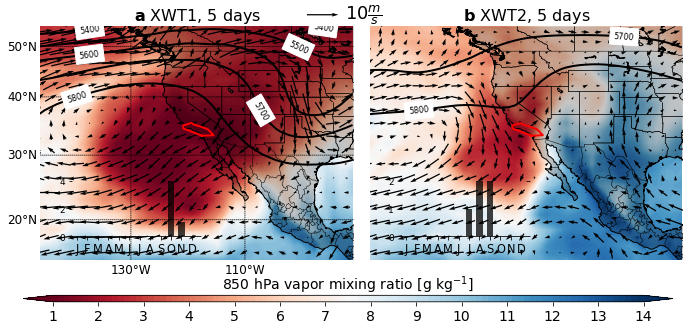

In [9]:
# Calculate the geometry of the plot dependent on how many panels there are
from Functions_Extreme_WTs import add_subplot_axes
PanWidth=4 # cm
PanHeight=2.5 # cm
xdist=0.5
ydist=0.5
Panels=EucledianDist_ERA2C.shape[1]
iColums=np.min([4,Panels])
iRows=np.max([1,int((math.ceil(Panels/4.)))])
iXX=[0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]
iYY=[0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]

X_Fig=PanWidth*iColums+xdist*(iColums+1)
Y_Fig=PanHeight*iRows+(iRows+1)

pe=1
re=1

plt.rcParams.update({'font.size': 18})
rgsLableABC=list(string.ascii_lowercase)
fig = plt.figure(figsize=(X_Fig,Y_Fig))
gs1 = gridspec.GridSpec(iRows,iColums)
gs1.update(left=0.05, right=0.99,
           bottom=0.20, top=0.92,
           wspace=0.05, hspace=0.20)
# rllcrnrlat,urcrnrlat,llcrnrlon,urcrnrlon=np.min(rgrLatPR_SR),np.max(rgrLatPR_SR),np.min(rgrLatPR_SR),np.max(rgrLatPR_SR)
dLat=((52-25)/2.)*1.5
dLon=(130-75)/2.
rllcrnrlat=np.mean((E20Lat2D.min(),E20Lat2D.max()))-dLat #      25 #rllcrnrlat-(urcrnrlat-rllcrnrlat)*0.03
urcrnrlat=np.mean((E20Lat2D.min(),E20Lat2D.max()))+dLat      #52 #urcrnrlat+(urcrnrlat-rllcrnrlat)*0.01
llcrnrlon=np.mean((E20Lon2D.min(),E20Lon2D.max()))-dLon #    -130 #llcrnrlon-abs(llcrnrlon-urcrnrlon)*0.01
urcrnrlon=np.mean((E20Lon2D.min(),E20Lon2D.max()))+dLon #     -75 #urcrnrlon+abs(llcrnrlon-urcrnrlon)*0.01
for pa in range(Panels):
    # define margins of subplot (see http://matplotlib.org/users/gridspec.html)
    iSampleSize=Xdays
    ax = plt.subplot(gs1[iYY[pa],iXX[pa]])
    try:
        m = Basemap(projection='cea',\
                    llcrnrlat= 14.125 ,urcrnrlat=54.625,\
                    llcrnrlon=-145.875,urcrnrlon=-90.875,resolution='l', fix_aspect=False)
    except:
        stop()
    plt.axis('off')
    xi, yi = m(E20Lon2D, E20Lat2D)
    rgrColorTable=['#a50026','#d73027','#f46d43','#fdae61','#fee090','#ffffff','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695'][::-1]

    # plot IVT
    biasContDist=10
    iContNr=len(rgrColorTable)+1
    clevs=np.linspace(1, 14,100) # np.linspace(1, 14,200)
    rgrDataAct=rgrWTcentroids[pe,pa, :,:,rgsWTvarsA.index('Q850')]*1000.
    cs = m.contourf(xi,yi,rgrDataAct,clevs,cmap='RdBu', extend='both', alpha=1, zlevel=20)
    # plot wind field
    iLev=1; iDist=2
    Q = plt.quiver(xi[::iDist, ::iDist],yi[::iDist, ::iDist],rgrWTcentroids[pe,pa,::iDist,::iDist,1],
                   rgrWTcentroids[pe,pa,::iDist,::iDist,2], units='width',zorder = 2, pivot='middle',width=0.004, scale=100)
    if pa == 0:
        qk = ax.quiverkey(Q, 0.95, 1.05, 10, r'$10 \frac{m}{s}$', labelpos='E') #,coordinates='figure')
    # plot geopotential height
    iContNr=20
    clevs=np.arange(0,10000,100)
    CS=m.contour(xi[:,:],yi[:,:],rgrWTcentroids[pe,pa,:,:,rgsWTvarsA.index('ZG500')]/9.81,levels=clevs.astype('int'),
                 colors='k',linewidths=2) #['#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#005a32'])
    clabels=plt.clabel(CS, inline=1, fontsize=8, fmt='%d')
    [txt.set_backgroundcolor('white') for txt in clabels]
    
#     # plot cluster region
#     iLatMax=E20Lat2D[rgiSrWT[0,:].max()]
#     iLatMin=E20Lat2D[rgiSrWT[0,:].min()]
#     iLonMax=E20Lon2D[rgiSrWT[1,:].max()]
#     iLonMin=E20Lon2D[rgiSrWT[1,:].min()]
#     lats = np.array([iLatMin, iLatMax, iLatMax, iLatMin,iLatMin])
#     lons = np.array([iLonMin, iLonMin, iLonMax, iLonMax, iLonMin])-360
#     x, y = m(lons,lats)
#     m.plot(x,y, lw=2, ls='--', c='r')

    # Lable the map
    plt.title(r"$\bf{" + str(rgsLableABC[pa]) + "}$"' XWT'+str(pa+1)+', '+str(iSampleSize)+' days', fontsize=16)

    m.drawcoastlines(color='k')
    m.drawcountries(color='k')
    m.drawstates(color='k')
    m.fillcontinents(color='k',lake_color='white', alpha=0.2)
    # add shapefile of catchment
    XX,YY=m(ctr[:,0], ctr[:,1])
    m.plot(XX,YY, c='r', lw=2)
    
    if pa == 0:
        parallels = np.arange(0.,81,10.)
        # labels = [left,right,top,bottom]
        m.drawparallels(parallels,labels=[True,False,True,False], fontsize=12)
        meridians = np.arange(10.,351.,20.)
        m.drawmeridians(meridians,labels=[True,False,False,True], fontsize=12)

    # Add Histogram in the lower left corner
    rect = [0.1,0.1,0.4,0.25]
    ax1 = add_subplot_axes(ax,rect)
    # plt.axis('off')
    if pa == 0:
        rgiExtremeDays=EXTREMEXWT1
    else:
        rgiExtremeDays=EXTREMEXWT2
    rgiMonths=np.array([rgiExtremeDays[nn].month for nn in range(len(rgiExtremeDays))])
    ax1.hist(rgiMonths,np.array(range(1,13,1))+0.5, facecolor='k', alpha=0.75,rwidth=0.6)#, normed=1
    ax1.set_xticks(np.array(range(1,13,1)))
    ax1.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.xaxis.set_ticks_position('bottom')
    ax1.set_xlim([0.5,12.5])
    # ax2.yaxis.set_ticks_position('left')
    ax1.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        right='off',         # ticks along the top edge are off
        labelleft='off') # labels along the bottom edge are off
    ax1.patch.set_alpha(0.0)

# add colorbar for IVT
CbarAx = axes([0.025, 0.07, 0.95, 0.02])
cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='max', ticks=np.arange(1,21,1))
cb.ax.tick_params(labelsize=14)
cb.ax.set_title('850 hPa vapor mixing ratio [g kg$^{-1}$]', fontsize=14)

sPlotFile=sPlotDir
# sPlotName= 'BottomUp-'+str(rgrClustersFin[1].max()+1)+'WT_Centroids.pdf'
sPlotName= 'Example_ERA20C-XWT-centroids-'+DW_Regions[re]+'.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print('        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)

### Plot the NOAA20C centroids

        Plot map to: /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/XWT_characteristics_changes/Example_NOAA20C-XWT-centroids-Central_Coast.pdf


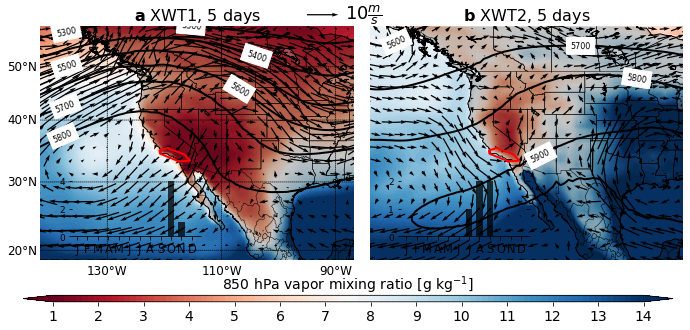

In [10]:
# Calculate the geometry of the plot dependent on how many panels there are
PanWidth=4 # cm
PanHeight=2.5 # cm
xdist=0.5
ydist=0.5
Panels=EucledianDist_ERA2C.shape[1]
iColums=np.min([4,Panels])
iRows=np.max([1,int((math.ceil(Panels/4.)))])
iXX=[0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]
iYY=[0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]

X_Fig=PanWidth*iColums+xdist*(iColums+1)
Y_Fig=PanHeight*iRows+(iRows+1)


plt.rcParams.update({'font.size': 18})
rgsLableABC=list(string.ascii_lowercase)
fig = plt.figure(figsize=(X_Fig,Y_Fig))
gs1 = gridspec.GridSpec(iRows,iColums)
gs1.update(left=0.05, right=0.99,
           bottom=0.20, top=0.92,
           wspace=0.05, hspace=0.20)
# rllcrnrlat,urcrnrlat,llcrnrlon,urcrnrlon=np.min(rgrLatPR_SR),np.max(rgrLatPR_SR),np.min(rgrLatPR_SR),np.max(rgrLatPR_SR)
dLat=((52-25)/2.)*1.5
dLon=(130-75)/2.
rllcrnrlat=np.mean((N20Lat2D.min(),N20Lat2D.max()))-dLat #      25 #rllcrnrlat-(urcrnrlat-rllcrnrlat)*0.03
urcrnrlat=np.mean((N20Lat2D.min(),N20Lat2D.max()))+dLat      #52 #urcrnrlat+(urcrnrlat-rllcrnrlat)*0.01
llcrnrlon=np.mean((N20Lon2D.min(),N20Lon2D.max()))-dLon #    -130 #llcrnrlon-abs(llcrnrlon-urcrnrlon)*0.01
urcrnrlon=np.mean((N20Lon2D.min(),N20Lon2D.max()))+dLon #     -75 #urcrnrlon+abs(llcrnrlon-urcrnrlon)*0.01
for pa in range(2):
    # define margins of subplot (see http://matplotlib.org/users/gridspec.html)
    iSampleSize=Xdays
    ax = plt.subplot(gs1[iYY[pa],iXX[pa]])
    m = Basemap(projection='cea',\
                    llcrnrlat= rllcrnrlat ,urcrnrlat=urcrnrlat,\
                    llcrnrlon=llcrnrlon,urcrnrlon=urcrnrlon,resolution='l', fix_aspect=False)
    plt.axis('off')
    xi, yi = m(N20Lon2D, N20Lat2D)
    rgrColorTable=['#a50026','#d73027','#f46d43','#fdae61','#fee090','#ffffff','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695'][::-1]

    # plot IVT
    biasContDist=10
    iContNr=len(rgrColorTable)+1
    clevs=np.linspace(1, 14,100) # np.linspace(1, 14,200)
    rgrDataAct=rgrWTcentroidsN[1,pa, :,:,rgsWTvarsN.index('Q2'),0]*1000
    cs = m.contourf(xi,yi,rgrDataAct,clevs,cmap='RdBu', extend='both', alpha=1, zlevel=20)
    # plot wind field
    iLev=1; iDist=3
    Q = plt.quiver(xi[::iDist, ::iDist],yi[::iDist, ::iDist],rgrWTcentroidsN[1,pa,::iDist,::iDist,0,0],
                   rgrWTcentroidsN[1,pa,::iDist,::iDist,1,0], units='width',zorder = 2, pivot='middle',width=0.004, scale=100)
    if pa == 0:
        qk = ax.quiverkey(Q, 0.95, 1.05, 10, r'$10 \frac{m}{s}$', labelpos='E') #,coordinates='figure')
    # Plot ZG500
    clevs=np.arange(0,10000,100)
    CS=m.contour(xi[:,:],yi[:,:],rgrWTcentroidsN[pe,pa,:,:,rgsWTvarsN.index('ZG500'),0],levels=clevs.astype('int'),
                 colors='k',linewidths=2) #['#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#005a32'])
    clabels=plt.clabel(CS, inline=1, fontsize=8, fmt='%d')
    [txt.set_backgroundcolor('white') for txt in clabels]

    # Lable the map
    plt.title(r"$\bf{" + str(rgsLableABC[pa]) + "}$"' XWT'+str(pa+1)+', '+str(iSampleSize)+' days', fontsize=16)

    m.drawcoastlines(color='k')
    m.drawcountries(color='k')
    m.drawstates(color='k')
    m.fillcontinents(color='k',lake_color='white', alpha=0.2)
    # add shapefile of catchment
    XX,YY=m(ctr[:,0], ctr[:,1])
    m.plot(XX,YY, c='r', lw=2)
    
    if pa == 0:
        parallels = np.arange(0.,81,10.)
        # labels = [left,right,top,bottom]
        m.drawparallels(parallels,labels=[True,False,True,False], fontsize=12)
        meridians = np.arange(10.,351.,20.)
        m.drawmeridians(meridians,labels=[True,False,False,True], fontsize=12)
        
        
    # Add Histogram in the lower left corner
    rect = [0.1,0.1,0.4,0.25]
    ax1 = add_subplot_axes(ax,rect)
    # plt.axis('off')
    if pa == 0:
        rgiExtremeDays=EXTREMEXWT1
    else:
        rgiExtremeDays=EXTREMEXWT2
    rgiMonths=np.array([rgiExtremeDays[nn].month for nn in range(len(rgiExtremeDays))])
    ax1.hist(rgiMonths,np.array(range(1,13,1))+0.5, facecolor='k', alpha=0.75,rwidth=0.6)#, normed=1
    ax1.set_xticks(np.array(range(1,13,1)))
    ax1.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.xaxis.set_ticks_position('bottom')
    ax1.set_xlim([0.5,12.5])
    # ax2.yaxis.set_ticks_position('left')
    ax1.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        right='off',         # ticks along the top edge are off
        labelleft='off') # labels along the bottom edge are off
    ax1.patch.set_alpha(0.0)
        
# add colorbar for IVT
CbarAx = axes([0.025, 0.07, 0.95, 0.02])
cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='max', ticks=np.arange(1,21,1))
cb.ax.tick_params(labelsize=14)
cb.ax.set_title('850 hPa vapor mixing ratio [g kg$^{-1}$]', fontsize=14)

sPlotFile=sPlotDir
# sPlotName= 'BottomUp-'+str(rgrClustersFin[1].max()+1)+'WT_Centroids.pdf'
sPlotName= 'Example_NOAA20C-XWT-centroids-'+DW_Regions[re]+'.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print('        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)

In [22]:
rgrWTcentroidsN[1,pa,::iDist,::iDist,0].shape

(25, 34, 80)

### Plot Amplitude Changes

        Plot map to: /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/XWT_characteristics_changes/XWT-amplitude-changes-NOAA20C-Central_Coast.pdf


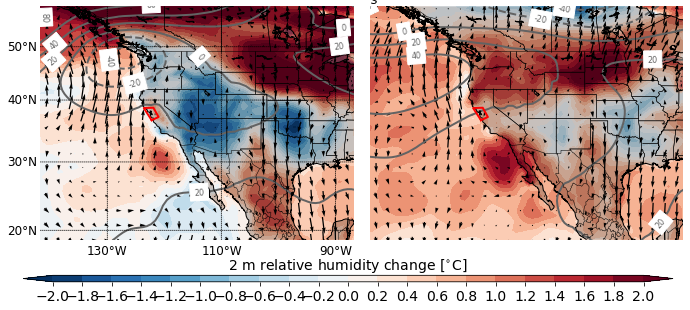

In [25]:
PanWidth=4 # cm
PanHeight=2.5 # cm
xdist=0.5
ydist=0.5
Panels=EucledianDist_ERA2C.shape[1]
iColums=np.min([4,Panels])
iRows=np.max([1,int((math.ceil(Panels/4.)))])
iXX=[0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]
iYY=[0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]

X_Fig=PanWidth*iColums+xdist*(iColums+1)
Y_Fig=PanHeight*iRows+(iRows+1)


plt.rcParams.update({'font.size': 18})
rgsLableABC=list(string.ascii_lowercase)
fig = plt.figure(figsize=(X_Fig,Y_Fig))
gs1 = gridspec.GridSpec(iRows,iColums)
gs1.update(left=0.05, right=0.99,
           bottom=0.20, top=0.92,
           wspace=0.05, hspace=0.20)
# rllcrnrlat,urcrnrlat,llcrnrlon,urcrnrlon=np.min(rgrLatPR_SR),np.max(rgrLatPR_SR),np.min(rgrLatPR_SR),np.max(rgrLatPR_SR)
dLat=((52-25)/2.)*1.5
dLon=(130-75)/2.
rllcrnrlat=np.mean((N20Lat2D.min(),N20Lat2D.max()))-dLat #      25 #rllcrnrlat-(urcrnrlat-rllcrnrlat)*0.03
urcrnrlat=np.mean((N20Lat2D.min(),N20Lat2D.max()))+dLat      #52 #urcrnrlat+(urcrnrlat-rllcrnrlat)*0.01
llcrnrlon=np.mean((N20Lon2D.min(),N20Lon2D.max()))-dLon #    -130 #llcrnrlon-abs(llcrnrlon-urcrnrlon)*0.01
urcrnrlon=np.mean((N20Lon2D.min(),N20Lon2D.max()))+dLon #     -75 #urcrnrlon+abs(llcrnrlon-urcrnrlon)*0.01
for pa in range(2):
    # define margins of subplot (see http://matplotlib.org/users/gridspec.html)
    ax = plt.subplot(gs1[iYY[pa],iXX[pa]])
    m = Basemap(projection='cea',\
                    llcrnrlat= rllcrnrlat ,urcrnrlat=urcrnrlat,\
                    llcrnrlon=llcrnrlon,urcrnrlon=urcrnrlon,resolution='l', fix_aspect=False)
    plt.axis('off')
    xi, yi = m(N20Lon2D, N20Lat2D)
    rgrColorTable=['#a50026','#d73027','#f46d43','#fdae61','#fee090','#ffffff','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695'][::-1]

    # plot T2M change
    iContNr=len(rgrColorTable)+1
    clevsT=np.arange(-2, 2.2,0.2) # [-6,-4, -3. , -2, -1.5, -1, -0.4, -0. ,  0.4,  1,  1.5,  2,  3. ,4,6] ;
    PAST = np.mean(rgrWTcentroidsN[0,pa, :,:,rgsWTvarsN.index('T2'),:],axis=2)
    CUR = np.mean(rgrWTcentroidsN[1,pa, :,:,rgsWTvarsN.index('T2'),:], axis=2)
#     SIG = np.zeros((rgrWTcentroidsN.shape[2],rgrWTcentroidsN.shape[3])); SIG[:] = np.nan
#     for la in range(rgrWTcentroidsN.shape[2]):
#         for lo in range(rgrWTcentroidsN.shape[3]):
#             SIG[la,lo] = scipy.stats.mannwhitneyu(rgrWTcentroidsN[0,pa, la,lo,rgsWTvarsN.index('T2'),:], rgrWTcentroidsN[1,pa,la,lo,rgsWTvarsN.index('T2'),:])[1]
    Diff = CUR - PAST
#     Diff[SIG > 0.025] = np.nan
    cs = m.contourf(xi,yi,Diff,clevsT,cmap='RdBu_r', extend='both', alpha=1, zlevel=20)

#     # plot RH2 change
#     iContNr=len(rgrColorTable)+1
#     clevsT=np.array([-6,-4, -3. , -2, -1.5, -1, -0.4, -0. ,  0.4,  1,  1.5,  2,  3. ,4,6])*2 #np.arange(-2, 2.2,0.2) # np.linspace(1, 14,200)
#     PAST = np.mean(rgrWTcentroidsN[0,pa, :,:,rgsWTvarsN.index('RH2'),:],axis=2)
#     CUR = np.mean(rgrWTcentroidsN[1,pa, :,:,rgsWTvarsN.index('RH2'),:], axis=2)
# #     SIG = np.zeros((rgrWTcentroidsN.shape[2],rgrWTcentroidsN.shape[3])); SIG[:] = np.nan
# #     for la in range(rgrWTcentroidsN.shape[2]):
# #         for lo in range(rgrWTcentroidsN.shape[3]):
# #             SIG[la,lo] = scipy.stats.mannwhitneyu(rgrWTcentroidsN[0,pa, la,lo,rgsWTvarsN.index('RH2'),:], rgrWTcentroidsN[1,pa,la,lo,rgsWTvarsN.index('RH2'),:])[1]
#     Diff = CUR - PAST
# #     Diff[SIG > 0.025] = np.nan
#     cs = m.contourf(xi,yi,Diff,clevsT,cmap='RdBu', extend='both', alpha=1, zlevel=20)

    # plot wind field
    PASU = np.mean(rgrWTcentroidsN[0,pa, :,:,rgsWTvarsN.index('U850'),:],axis=2)
    CURU = np.mean(rgrWTcentroidsN[1,pa, :,:,rgsWTvarsN.index('U850'),:], axis=2)
    DiffU = CURU - PASU
    PASV = np.mean(rgrWTcentroidsN[0,pa, :,:,rgsWTvarsN.index('V850'),:],axis=2)
    CURV = np.mean(rgrWTcentroidsN[1,pa, :,:,rgsWTvarsN.index('V850'),:], axis=2)
    DiffV = CURU - PASV
    iLev=1; iDist=3
    Q = plt.quiver(xi[::iDist, ::iDist],yi[::iDist, ::iDist],DiffU[::iDist,::iDist],DiffV[::iDist,::iDist], 
                   units='width',zorder = 2, pivot='middle',width=0.004, scale=150)
    if pa == 0:
        qk = ax.quiverkey(Q, 0.95, 1.05, 10, r'$10 \frac{m}{s}$', labelpos='E') #,coordinates='figure')

    # Plot ZG500
    PAST = np.mean(rgrWTcentroidsN[0,pa, :,:,rgsWTvarsN.index('ZG500'),:],axis=2)
    CUR = np.mean(rgrWTcentroidsN[1,pa, :,:,rgsWTvarsN.index('ZG500'),:], axis=2)
    Diff = CUR - PAST
    clevs=np.arange(-200,200,20)
    CS=m.contour(xi[:,:],yi[:,:],Diff,levels=clevs.astype('int'),
                 colors='#636363',linewidths=2) #['#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#005a32'])
    clabels=plt.clabel(CS, inline=1, fontsize=8, fmt='%d')
    [txt.set_backgroundcolor('white') for txt in clabels]

#     # Lable the map
#     plt.title(r"$\bf{" + str(rgsLableABC[pa]) + "}$"' XWT'+str(pa+1)+', '+str(iSampleSize)+' days', fontsize=16)

    m.drawcoastlines(color='k')
    m.drawcountries(color='k')
    m.drawstates(color='k')
    m.fillcontinents(color='k',lake_color='white', alpha=0.2)
    # add shapefile of catchment
    XX,YY=m(ctr[:,0], ctr[:,1])
    m.plot(XX,YY, c='r', lw=2)
    
    if pa == 0:
        parallels = np.arange(0.,81,10.)
        # labels = [left,right,top,bottom]
        m.drawparallels(parallels,labels=[True,False,True,False], fontsize=12)
        meridians = np.arange(10.,351.,20.)
        m.drawmeridians(meridians,labels=[True,False,False,True], fontsize=12)
        
# add colorbar for IVT
CbarAx = axes([0.025, 0.07, 0.95, 0.02])
cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='max', ticks=clevsT)
cb.ax.tick_params(labelsize=14)
cb.ax.set_title('2 m relative humidity change [$^{\circ}$C]', fontsize=14)


sPlotFile=sPlotDir
# sPlotName= 'BottomUp-'+str(rgrClustersFin[1].max()+1)+'WT_Centroids.pdf'
sPlotName= 'XWT-amplitude-changes-NOAA20C-'+DW_Regions[re]+'.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print('        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)



In [130]:
sPlotFile

'/glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/XWT_characteristics_changes/'

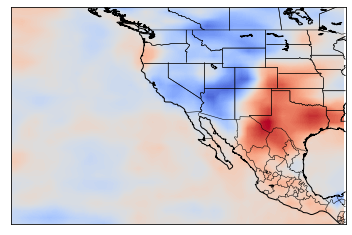

In [26]:
XWT=0
PAST = rgrWTcentroids[0,XWT, :,:,rgsWTvarsA.index('RH2')]
CUR = rgrWTcentroids[1,XWT, :,:,rgsWTvarsA.index('RH2')]
# Diff = ((CUR - PAST)/PAST)*100.
Diff = CUR - PAST

m = Basemap(projection='cea',\
            llcrnrlat= 14.125 ,urcrnrlat=54.625,\
            llcrnrlon=-145.875,urcrnrlon=-90.875,resolution='l', fix_aspect=False)
xi, yi = m(E20Lon2D, E20Lat2D)
plt.contourf(xi,yi,Diff, levels=np.linspace(-20,20,100), cmap='coolwarm', extend='both')
m.drawcoastlines(color='k')
m.drawcountries(color='k')
m.drawstates(color='k')
# m.fillcontinents(color='k',lake_color='white', alpha=0.2)

In [69]:
Diff.shape

(75, 100)

TypeError: Shapes of x (75, 100) and z (50, 60) do not match

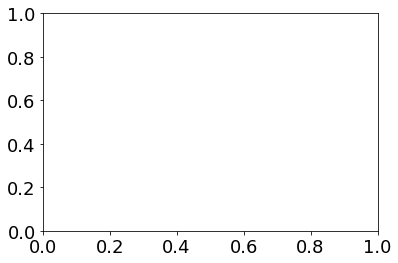

In [27]:
m = Basemap(projection='cea',\
            llcrnrlat= 14.125 ,urcrnrlat=54.625,\
            llcrnrlon=-145.875,urcrnrlon=-90.875,resolution='l', fix_aspect=False)
xi, yi = m(N20Lon2D, N20Lat2D)
plt.contourf(xi,yi,PAST-273.15, levels=np.linspace(10,35), extend='both', cmap='coolwarm')
m.drawcoastlines(color='k')
m.drawcountries(color='k')
m.drawstates(color='k')

### Plot maps showing the differences

In [28]:
plt.rcParams.update({'font.size': 14})
rgsLableABC=list(string.ascii_lowercase)
fig = plt.figure(figsize=(18,12))
gs1 = gridspec.GridSpec(2,4)
gs1.update(left=0.01, right=0.99,
           bottom=0.47, top=0.94,
           wspace=0.05, hspace=0.20)
Lon2D,Lat2D=np.meshgrid(LonWT1D, LatWT1D)

m = Basemap(projection='cea',\
            llcrnrlat= LatWT1D.min()+5 ,urcrnrlat=LatWT1D.max()-10,\
            llcrnrlon=LonWT1D.min()+10,urcrnrlon=LonWT1D.max()-15,resolution='l', fix_aspect=False)
xi,yi=m(Lon2D,Lat2D)

for va in range(len(VarsFullName)):
    for pe in range(2):
        if pe == 0:
            sPer='2020-2050 $-$ 1990-2020'
        if pe == 1:
            sPer='2070-2100 $-$ 1990-2020'

        if VarsFullName[va] == 'TREFHT':
            DATA=(np.mean(XWTdata[pe+1,:,:,:,:,VarsFullName.index('TREFHT')], axis=(0,1))-np.mean(XWTdata[0,:,:,:,:,VarsFullName.index('TREFHT')], axis=(0,1)))
            Unit='[$^{\circ}$C]'
            LEVELS=np.linspace(-5,5,11)
            CMAP='coolwarm'
        if VarsFullName[va] == 'TMQ':
            DATA=((np.mean(XWTdata[pe+1,:,:,:,:,VarsFullName.index('TMQ')], axis=(0,1))-np.mean(XWTdata[0,:,:,:,:,VarsFullName.index('TMQ')], axis=(0,1)))/\
                    np.mean(XWTdata[0,:,:,:,:,VarsFullName.index('TMQ')], axis=(0,1)))*100.
            Unit='[%]'
            LEVELS=np.linspace(-30,30,11)
            CMAP='coolwarm_r'
        if VarsFullName[va] == 'PRECT':            
            DATA=(np.mean(XWTdata[pe+1,:,:,:,:,VarsFullName.index('PRECT')], axis=(0,1))-np.mean(XWTdata[0,:,:,:,:,VarsFullName.index('PRECT')], axis=(0,1)))
            Unit='[mm d$^{-1}$]'
            LEVELS=np.linspace(-5,5,11)
            # Changes in percent
            DATAP=((np.mean(XWTdata[pe+1,:,:,:,:,VarsFullName.index('PRECT')], axis=(0,1))-np.mean(XWTdata[0,:,:,:,:,VarsFullName.index('PRECT')], axis=(0,1)))/\
                    np.mean(XWTdata[0,:,:,:,:,VarsFullName.index('PRECT')], axis=(0,1)))*100
            DATAP[np.mean(XWTdata[0,:,:,:,:,VarsFullName.index('PRECT')], axis=(0,1)) < 2]=np.nan
            UnitP='[mm d$^{-1}$]'
            LEVELSP=np.linspace(-35,35,11)
            CMAP='coolwarm_r'
        if VarsFullName[va] == 'PSL':
            DATA=(np.mean(XWTdata[pe+1,:,:,:,:,VarsFullName.index('PSL')], axis=(0,1))-np.mean(XWTdata[0,:,:,:,:,VarsFullName.index('PSL')], axis=(0,1)))
            Unit='[Pa]'
            LEVELS=np.linspace(-150,150,11)
            CMAP='coolwarm'
        SIG=significant(XWTdata[pe+1,:,:,:,:,VarsFullName.index(VarsFullName[va])], XWTdata[0,:,:,:,:,VarsFullName.index(VarsFullName[va])])
        
        # VarsFullName=  ['TREFHT','TMQ','PRECT','PSL']
        ax = plt.subplot(gs1[pe,va])
        if VarsFullName[va] != 'PRECT':
            cs=m.contourf(xi,yi,DATA, levels=LEVELS, cmap=CMAP,extend='both')
        else:
            cs=m.contourf(xi,yi,DATA, levels=LEVELS, cmap=CMAP,extend='both')
            cl=m.contour(xi,yi,DATAP, levels=[-30-15,15,30], colors='k', linewidths=2)
            clabels=plt.clabel(cl, inline=1, fontsize=8, fmt='%d')
#             [txt.set_backgroundcolor('white') for txt in clabels]
        plt.contourf(xi,yi,SIG[:,:], hatches=['...',''], levels=[0, 0.05, 1.1], colors='none', zorder=3)
        m.drawcoastlines(color='k')
        m.drawcountries(color='k')
        m.drawstates(color='k')
        plt.axis('off')

        if (va == 0) & (pe ==0):
            parallels = np.arange(0.,81,10.)
            # labels = [left,right,top,bottom]
            m.drawparallels(parallels,labels=[True,False,True,False], fontsize=12)
            meridians = np.arange(10.,351.,20.)
            m.drawmeridians(meridians,labels=[True,False,False,True], fontsize=12)

        tt = ax.text(0.03,1.01, rgsLableABC[pe+va*2]+') '+VarsFullName[va]+' '+sPer , ha='left',va='bottom', \
                                     transform = ax.transAxes, fontname="Times New Roman Bold", fontsize=14)
        if pe == 1:
            pos1=ax.get_position()
            CbarAx = axes([pos1.x0, pos1.y0-0.04, pos1.width, 0.015])
            cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='max', ticks=LEVELS)
            cb.ax.tick_params(labelsize=14)
            cb.ax.set_title('$\Delta$ '+VarsFullName[va]+' '+Unit, fontsize=14)
            cb.ax.tick_params(labelsize=10)

# Save the plot
# plt.show()
sPlotFile=sPlotDir
# sPlotName= 'BottomUp-'+str(rgrClustersFin[1].max()+1)+'WT_Centroids.pdf'
sPlotName= Region+'_EnvironmentalDiff_'+str("%03d" % XWTdates.shape[2])+'_'+Season+'.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print '        Plot map to: '+sPlotFile+sPlotName
fig.savefig(sPlotFile+sPlotName)

SyntaxError: Missing parentheses in call to 'print'. Did you mean print('        Plot map to: '+sPlotFile+sPlotName)? (<ipython-input-28-4d0d748495f8>, line 90)

### Plot the current precipitation

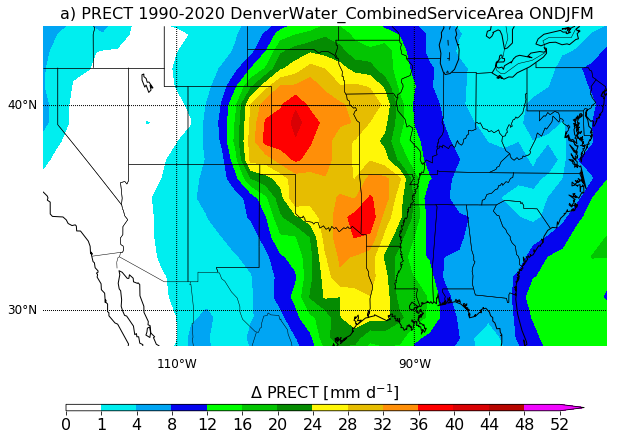

In [29]:
plt.rcParams.update({'font.size': 14})
rgsLableABC=list(string.ascii_lowercase)
fig = plt.figure(figsize=(8,6))
gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.01, right=0.99,
           bottom=0.20, top=0.94,
           wspace=0.05, hspace=0.20)

sPer='1990-2020'
m = Basemap(projection='cea',\
            llcrnrlat= LatWT1D.min()+10 ,urcrnrlat=LatWT1D.max()-25,\
            llcrnrlon=LonWT1D.min()+20,urcrnrlon=LonWT1D.max()-25,resolution='l', fix_aspect=False)
xi,yi=m(Lon2D,Lat2D)
ax = plt.subplot(gs1[0,0])

DATA=np.reshape(XWTdata[0,:,:,:,:,VarsFullName.index('PRECT')], (XWTdata.shape[1]*XWTdata.shape[2],XWTdata.shape[3],XWTdata.shape[4]))
rgrDataAct=np.mean(DATA, axis=(0))
rgrDataAct=np.percentile(DATA, 90, axis=(0))
Unit='[mm d$^{-1}$]'
LEVELS=np.linspace(0,52,21)

rgrColorTable=['#00eeef','#00a5f3','#0505ef','#00ff00','#03c502','#058c02','#fff707','#e6bd01','#ff8f08','#ff0000','#d90104','#b70500','#f107fe']
biasContDist=4 #8
iContNr=len(rgrColorTable)+1
clevs=np.arange(0, iContNr*biasContDist,biasContDist)# ; clevs.astype('float')
clevs=np.append([0],clevs); clevs[1]=1
rgrColorTable=np.append(['#ffffff'],rgrColorTable)
cs = m.contourf(xi,yi,rgrDataAct,clevs,colors=rgrColorTable, extend='max')

# cs=m.contourf(xi,yi,DATA, levels=LEVELS, cmap=CMAP,extend='max')
m.drawcoastlines(color='k')
m.drawcountries(color='k')
m.drawstates(color='k')
plt.axis('off')

parallels = np.arange(0.,81,10.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,True,False], fontsize=12)
meridians = np.arange(10.,351.,20.)
m.drawmeridians(meridians,labels=[True,False,False,True], fontsize=12)

tt = ax.text(0.03,1.01, rgsLableABC[0]+') '+VarsFullName[VarsFullName.index('PRECT')]+' '+sPer+' '+Region+' '+Season , ha='left',va='bottom', \
                             transform = ax.transAxes, fontname="Times New Roman Bold", fontsize=16)

CbarAx = axes([0.05, 0.05, 0.9, 0.015])
cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='max', ticks=clevs)
cb.ax.tick_params(labelsize=16)
cb.ax.set_title('$\Delta$ '+VarsFullName[VarsFullName.index('PRECT')]+' '+Unit, fontsize=16)
cb.ax.tick_params(labelsize=16)

In [210]:
XWTdata[0,:,:,:,:,VarsFullName.index('PRECT')].shape

(40, 3, 55, 75)

In [211]:
XWTdata.shape

(3, 40, 3, 55, 75, 4)